# Velocity control of the end-effector

In [1]:
#setup nice plotting (use widget instead of notebook in the command below if you use jupyter lab)
%matplotlib inline

# we import useful libraries
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from  mpl_toolkits.mplot3d import Axes3D

use_real_robot_computer = False
use_real_robot = False

if use_real_robot_computer:
    from nyu_finger import NYUFingerReal
    from nyu_finger_sim.nyu_finger_simulator import NYUFingerSimulator
else:
    from nyu_finger_simulator import NYUFingerSimulator


import robot_kinematics

## 3D Forward Kinematics
We now consider the complete 3D forward kinematics of the robot as depicted in the following figure. It means that we now take into account $\theta_0$, the sideway motion. In order to do so we need to add a new frame $H_1$ and we rename the hip frame as $H_2$ as it comes after the $\theta_0$ motion in the chain.
We also add a frame at the foot that is oriented like the base frame, we call it $O$ (in dashed line on the picture)
![](./3d_kinematics.png)


## Jacobians of the end-effector
We will also compute the space and body Jacobians of the end-effector. Further, we will compute the Jacobian of the end-effector with respect to the frame O (i.e. the frame attached at the foot but oriented like the space frame)

## The robot_kinematics class
In the package robot_kinematics (in the file __[robot_kinematics.py](./robot_kinematics.py)__ ) we have written functionalities to do the forward kinematics and compute the Jacobians of interest. The code below shows how to use the class, update the kinematics with the current joint angles and retrieve quantities of interest

In [2]:
# example of utilisation of the robot_kinematics class

# we create an object
kin = robot_kinematics.robot_kinematics()

# we update the kinematics with some joint angles
q = np.array([0.,0,0])
kin.update_kinematics(q)

# we print the Jacobian from frame O
print("the Jacobian in Frame O is")
print(kin.orientedJ)
print('\n')

# we print the space Jacobian
print("the Space Jacobian is")
print(kin.spatialJ)
print('\n')

# we print the body Jacobian
print("the body Jacobian is")
print(kin.bodyJ)
print('\n')

# we print the position of the foot
print("The position of the foot in S frame is")
print(kin.TS_F[0:3,3])

the Jacobian in Frame O is
[[ 1.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     1.     1.   ]
 [ 0.     0.32   0.16 ]
 [-0.014  0.     0.   ]
 [-0.32   0.     0.   ]]


the Space Jacobian is
[[ 1.    0.    0.  ]
 [ 0.    0.    0.  ]
 [ 0.    1.    1.  ]
 [ 0.    0.   -0.16]
 [ 0.   -0.3  -0.3 ]
 [ 0.    0.    0.  ]]


the body Jacobian is
[[ 1.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     1.     1.   ]
 [ 0.     0.32   0.16 ]
 [-0.014  0.     0.   ]
 [-0.32   0.     0.   ]]


The position of the foot in S frame is
[ 0.3   -0.32   0.014]


## End-effector velocities

Last laboratory, we used analytic IK to compute desired positions for the joint angles that would ensure we reach a desired position (touching the pink balls). Then we generated a straight line trajectory in joint space and used the joint PD controller to track this trajectory.

Today, we will use the fact that $$\mathcal{V}_{SO}^O = J_O(\boldsymbol{\theta}) \cdot \dot{\boldsymbol{\theta}}$$ 
to derive directly a controller acting in the foot space. 
Here $\boldsymbol{\theta} = [\theta_0, \theta_1, \theta_2]$ is the vector containing all the joint positions.
We will generate directly generate trajectories for the foot and follow them without ever explicitly computing the inverse kinematics of the robot.

If we only look at the linear velocity of point O (i.e. the velocity of the foot with respect to the spatial frame), we can decompose the Jacobian into two part (the top 3 rows are associated to the angular velocity of the foot and the bottom 3 are associated to the linear velocity): $$J_O(\boldsymbol{\theta}) = \begin{bmatrix} J_{O\omega} \\ J_{Ov} \end{bmatrix}$$
and we can write the velocity equation as
$$\mathcal{V}_{SO}^O = \begin{pmatrix} \omega_O \\ v_O \end{pmatrix} = \begin{bmatrix} J_{O\omega} \\ J_{Ov} \end{bmatrix} \cdot \dot{\boldsymbol{\theta}}$$

So the linear velocity of the foot is $$v_O = J_{Ov} \dot{\boldsymbol{\theta}}$$

Because our robot have 3 joints, away from singular configurations, the matrix $$J_{Ov}$$ (which is 3x3) will be invertible. It means that the joint velocity at achieve a desired foot velocity is
$$ \dot{\boldsymbol{\theta}} = J_{Ov}^{-1} v_O$$

## End-effector control

If we have a desired velocity we would like to achieve for the foot, we can then directly convert it into a desired velocity for the joints. Then we could use our joint PD controller where we would remove the P part to track this joint space velocity.

Assume we have a reference foot trajectory (e.g. coming from our trajectory generator that create smooth trajectories from a starting point to a desired goal with 0 velocities and accelerations at the beginning and end of the trajectories). At each instant of time, we then get $x_{ref}$ and $\dot{x}_{ref}$, the desired position and velocity of the foot. Our desired foot velocity (which is different from the target) could then be a combination between the reference velocity and an error correction term to make sure we stay on the trajectory
$$v_O = \dot{x}_{ref} + P (x_{ref} - x_{measured})$$

and so the desired joint velocities would be
$$\dot{\boldsymbol{\theta}}_{des} = J_{Ov}^{-1} \left( \dot{x}_{ref} + P (x_{ref} - x_{measured}) \right)$$

and the command sent to the robot
$$\tau = D(\dot{\boldsymbol{\theta}}_{des} - \dot{\boldsymbol{\theta}}_{measured})$$

where D is the gain we used in our previous lab for the PD control (the P in the PD controller being canceled).

## Dealing with singularities (very important!!)

We have seen in class that the Jacobian becomes singular, i.e. non invertible, when $\theta_2 = 0$. In this case, our control law will not be well defined because the Jacobian cannot be inverted (we will see in class how to deal with this situation too later).

For now, there are 2 simple ways to handle this situation:
1. Make sure the robot never reaches a singular configuration, whenever $|\theta_2| < 0.05$ stop everything.
2. When $|\theta_2| < 0.05$ (i.e. we are close to a singularity), we can change the matrix to inverse to make it invertible by replacing $J_{Ov}^{-1}$ by $(J_{Ov} + \epsilon I)^{-1}$ where $\epsilon$ is a small number, e.g. 10e-4.

## Questions
1. Write a controller that can draw a circle in the x-y plane. We would like to follow the 3D foot trajectory $$x_{ref}(t) = \begin{pmatrix} 0.3 + 0.05\cos(\omega t) \\ -0.2 + 0.05 \sin(\omega t) \\ 0 \end{pmatrix}$$
where $\omega = \pi$ is the frequency of rotation around the circle (frequency of rotation of $0.5Hz$).
2. Using the Jacobian, compute the velocity of the foot when performing the task
3. Plot the simulated trajectories of the foot (position and velocity) vs. the reference one
4. Now write a controller that can do a "figure 8" in the x-y plan $$x_{ref}(t) = \begin{pmatrix} 0.35 + 0.08\sin(\omega t) \\ -0.15 + 0.08 \cos(\omega t) \sin(\omega t) \\ 0 \end{pmatrix}$$ and plot the results as before
5. (Optional) Write a controller that can do the same "figure 8" in the x-z plane and plot the results as before
6. (Optional) Test the controller(s) on the real robot and plot the same plots as for the simulation

In [3]:
# we create a robot simulation
if use_real_robot:
    robot = NYUFingerReal()
    robot.initialize('enp5s0f1')
    # the PD gains
    P = np.array([1.5, 1.5, 1.5])
    D = np.array([0.1, 0.1, 0.1])
else:
    robot = NYUFingerSimulator()
    # we reset the simulation to the initial position we want to move
    robot.reset_state(np.array([0.0,0.0,0.1]))
    # we simulate for 7 seconds
    
    # the PD gains
    P = np.array([3., 3., 3.])
    D = np.array([0.3, 0.3, 0.3])

### Q1

In [4]:
# we simulate for 7 seconds
run_time = 8
dt = 0.001
num_steps = int(run_time/dt)

# we create our kinematic object
kin = robot_kinematics.robot_kinematics()

# we store information
# here we create some arrays that we use to store data generated during the control loop
measured_positions = np.zeros([num_steps,3]) # will store the measured position
measured_velocities = np.zeros_like(measured_positions) # will store the measure velocities

desired_torques = np.zeros_like(measured_positions) # will store the commands we send to the robot
desired_positions = np.zeros_like(measured_positions) # will store the desired positions we use in the PD controller
desired_velocities = np.zeros_like(measured_positions) # will store the desired velocities

desired_foot_positions = np.zeros([num_steps, 3])
desired_foot_velocities = np.zeros([num_steps, 3])

simulation_time = np.zeros([num_steps]) # will store the running time

x_pos = np.zeros([num_steps]) # will store the x position of the foot (as computed by Forw. Kin.)
y_pos = np.zeros([num_steps]) # will store the y position of the foot (as computed by Forw. Kin.)
z_pos = np.zeros([num_steps]) # will store the z position of the foot (as computed by Forw. Kin.)

x_vel = np.zeros([num_steps]) # will store the x velocity of the foot 
y_vel = np.zeros([num_steps]) # will store the y velocity of the foot 
z_vel = np.zeros([num_steps]) # will store the z velocity of the foot 

# now we can enter the main control loop (each loop is 1 control cycle)
for i in range(num_steps):

    # get the current time and store it
    simulation_time[i] = dt * i

    # we get the position and velocities of the joints and save them
    q, dq = robot.get_state()
    measured_positions[i,:] = q
    measured_velocities[i,:] = dq

    # save the current position of the foot using the FK function    
    kin.update_kinematics(q)
    x_pos[i] = kin.TS_F[0,3]
    y_pos[i] = kin.TS_F[1,3]
    z_pos[i] = kin.TS_F[2,3]

    # the P gain for the velocity control (cf. equations above)
    gain = 2.

    ####FILLL HERE THE VELOCITY CONTROLLER
    x_measured = np.array([kin.TS_F[0,3],
                           kin.TS_F[1,3],
                           kin.TS_F[2,3]])
    
    w = np.pi
    t = dt * i
    x_ref = np.array([0.3 + 0.05 * np.cos(w * t),
                     -0.2 + 0.05 * np.sin(w * t),
                      0.])
    dx_ref = np.array([-0.05 * w * np.sin(w * t),
                       0.05 * w * np.cos(w * t),
                       0.])
    
    desired_foot_positions[i] = x_ref
    desired_foot_velocities[i] = dx_ref
    
    Jov = kin.orientedJ[3:6, :]
    x_vel[i], y_vel[i], z_vel[i] = Jov @ dq
    if np.abs(q[2] < 0.05):
        Jov_inv = np.linalg.pinv(Jov + 1e-4*np.eye(3))
    else:
        Jov_inv = np.linalg.pinv(Jov)
    
    dx_des = dx_ref + gain * (x_ref - x_measured)
    dq_des = Jov_inv @ dx_des

    desired_positions[i,:] = q # there is no desired joint position so we just store the current one
    desired_velocities[i,:] = dq_des

    d_error = dq_des - dq # the velocity error for all the joints

    # we compute the desired torques as a PD controller
    joint_torques = D * d_error
    desired_torques[i,:] = joint_torques

    # we send them to the robot and do one simulation step
    robot.send_joint_torque(joint_torques)
    robot.step()

In [5]:
l0 = 0.3
l1 = 0.16
l2 = 0.16
l3 = 0.014

def plot_foot_trajectory(x_pos, y_pos, z_pos):
    """
    plots the position of the foot in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """    
    fig = plt.figure(figsize=(10,3.5))
    plt.subplot(1,2,1)
    plt.plot(x_pos,y_pos)
    plt.xlabel('foot x position [m]')
    plt.ylabel('foot y position [m]')
    plt.plot([0],[0],'o',markersize=15,color='r')
    
    plt.subplot(1,2,2)
    plt.plot(x_pos,z_pos)
    plt.xlabel('foot x position [m]')
    plt.ylabel('foot z position [m]')
    plt.plot([0],[0],'o',markersize=15,color='r')
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot3D(x_pos,z_pos,y_pos)
    plt.xlabel('foot x position [m]')
    plt.ylabel('foot z position [m]')
    ax.plot3D([0],[0],[0],'o',markersize=15,color='r')
    
# plot_foot_trajectory(x_pos, y_pos, z_pos)

In [6]:
def plot_joint_posvel(time, th, th_des, dth, dth_des):
    fig = plt.figure(figsize=(9,9))
    for i in range(3):
        plt.subplot(3,2,i*2+1)
        plt.plot(time, th[:,i], 'b-', time, th_des[:,i], '--k')
        plt.ylabel(r'$\theta_'+f'{i}$')
        plt.subplot(3,2,i*2+2)
        plt.plot(time, dth[:,i], 'b-', time, dth_des[:,i], '--k')
        plt.ylabel(r'$\dot{\theta}_' + f'{i}$')
        plt.xlabel('Time [s]')
    
# plot_joint_posvel(simulation_time, measured_positions, desired_positions, measured_velocities, desired_velocities)

### Q2
The foot velocity is the linear velocity of the frame {O}, hence
$v_O = J_{Ov}\dot{\theta}$

### Q3

In [7]:
font = {'family' : 'serif',
        'size'   : 22}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3, linewidth=200, suppress=True)

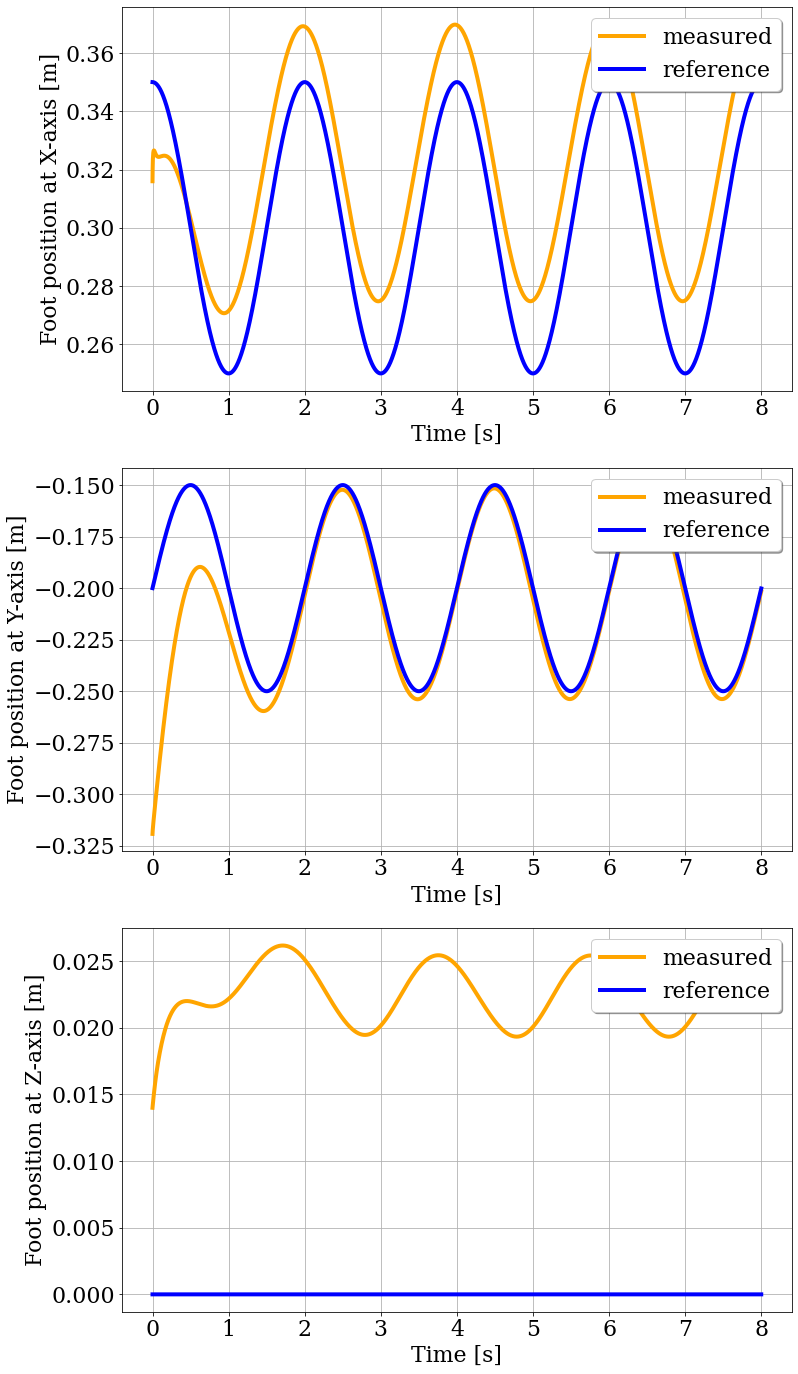

In [8]:
def plot_foot_positions(t, measured_foot_positions, desired_foot_positions):
    fig, ax = plt.subplots(3, 1, figsize=(12, 8*3))
    labels = ['X', 'Y', 'Z']

    for i in range(3):
        ax[i].plot(simulation_time, measured_foot_positions[:, i], 
                   lw=4, color='orange',
                   label='measured')
        ax[i].plot(simulation_time, desired_foot_positions[:, i], 
                   lw=4, color='blue',
                   label='reference')

        ax[i].grid()
        ax[i].set_xlabel('Time [s]')
        ax[i].set_ylabel(f'Foot position at {labels[i]}-axis [m]' )
        _ = ax[i].legend(loc='upper right', ncol=1, fancybox=True, shadow=True)
        
measured_foot_positions = np.vstack((x_pos, y_pos, z_pos)).T
plot_foot_positions(simulation_time, measured_foot_positions, desired_foot_positions)

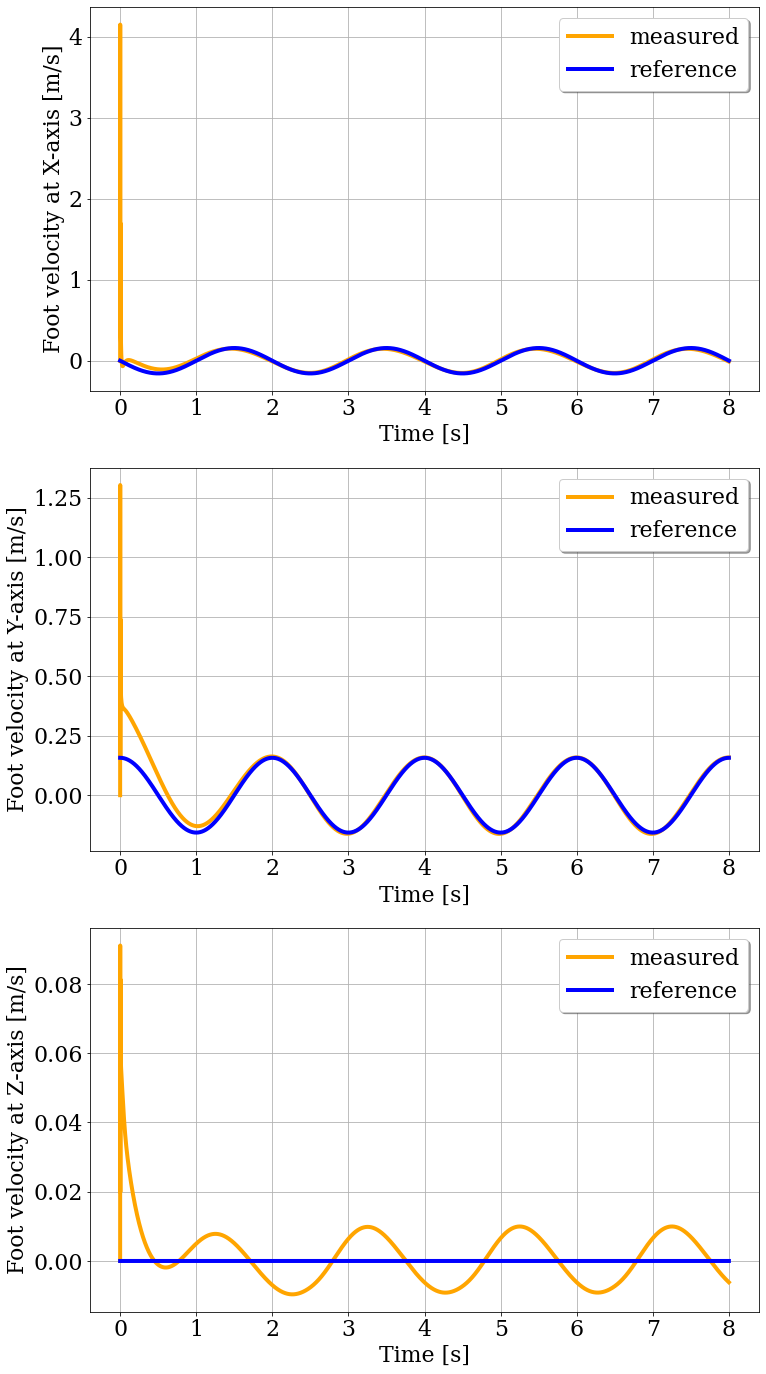

In [9]:
def plot_foot_velocities(t, measured_foot_velocities, desired_foot_velocities):
    fig, ax = plt.subplots(3, 1, figsize=(12, 8*3))
    labels = ['X', 'Y', 'Z']

    for i in range(3):
        ax[i].plot(simulation_time, measured_foot_velocities[:, i], 
                   lw=4, color='orange',
                   label='measured')
        ax[i].plot(simulation_time, desired_foot_velocities[:, i], 
                   lw=4, color='blue',
                   label='reference')

        ax[i].grid()
        ax[i].set_xlabel('Time [s]')
        ax[i].set_ylabel(f'Foot velocity at {labels[i]}-axis [m/s]' )
        _ = ax[i].legend(loc='upper right', ncol=1, fancybox=True, shadow=True)

measured_foot_velocities = np.vstack((x_vel, y_vel, z_vel)).T
plot_foot_velocities(simulation_time, measured_foot_velocities, desired_foot_velocities)

### Q4

In [10]:
# we simulate for 7 seconds
run_time = 8
dt = 0.001
num_steps = int(run_time/dt)

# we create our kinematic object
kin = robot_kinematics.robot_kinematics()

# we store information
# here we create some arrays that we use to store data generated during the control loop
measured_positions = np.zeros([num_steps,3]) # will store the measured position
measured_velocities = np.zeros_like(measured_positions) # will store the measure velocities

desired_torques = np.zeros_like(measured_positions) # will store the commands we send to the robot
desired_positions = np.zeros_like(measured_positions) # will store the desired positions we use in the PD controller
desired_velocities = np.zeros_like(measured_positions) # will store the desired velocities

desired_foot_positions = np.zeros([num_steps, 3])
desired_foot_velocities = np.zeros([num_steps, 3])

simulation_time = np.zeros([num_steps]) # will store the running time

x_pos = np.zeros([num_steps]) # will store the x position of the foot (as computed by Forw. Kin.)
y_pos = np.zeros([num_steps]) # will store the y position of the foot (as computed by Forw. Kin.)
z_pos = np.zeros([num_steps]) # will store the z position of the foot (as computed by Forw. Kin.)

x_vel = np.zeros([num_steps]) # will store the x velocity of the foot 
y_vel = np.zeros([num_steps]) # will store the y velocity of the foot 
z_vel = np.zeros([num_steps]) # will store the z velocity of the foot 

# now we can enter the main control loop (each loop is 1 control cycle)
for i in range(num_steps):

    # get the current time and store it
    simulation_time[i] = dt * i

    # we get the position and velocities of the joints and save them
    q, dq = robot.get_state()
    measured_positions[i,:] = q
    measured_velocities[i,:] = dq

    # save the current position of the foot using the FK function    
    kin.update_kinematics(q)
    x_pos[i] = kin.TS_F[0,3]
    y_pos[i] = kin.TS_F[1,3]
    z_pos[i] = kin.TS_F[2,3]

    # the P gain for the velocity control (cf. equations above)
    gain = 2.

    ####FILLL HERE THE VELOCITY CONTROLLER
    x_measured = np.array([kin.TS_F[0,3],
                           kin.TS_F[1,3],
                           kin.TS_F[2,3]])
    
    w = np.pi
    t = dt * i
    x_ref = np.array([0.35 + 0.08 * np.sin(w * t),
                     -0.15 + 0.08 * np.sin(w * t) * np.cos(w * t),
                      0.])
    dx_ref = np.array([0.08 * w * np.cos(w * t),
                       0.08 * w * np.cos(2 * w * t),
                       0.])
    
    desired_foot_positions[i] = x_ref
    desired_foot_velocities[i] = dx_ref
    
    Jov = kin.orientedJ[3:6, :]
    x_vel[i], y_vel[i], z_vel[i] = Jov @ dq
    if np.abs(q[2] < 0.05):
        Jov_inv = np.linalg.pinv(Jov + 1e-4*np.eye(3))
    else:
        Jov_inv = np.linalg.pinv(Jov)
    
    dx_des = dx_ref + gain * (x_ref - x_measured)
    dq_des = Jov_inv @ dx_des

    desired_positions[i,:] = q # there is no desired joint position so we just store the current one
    desired_velocities[i,:] = dq_des

    d_error = dq_des - dq # the velocity error for all the joints

    # we compute the desired torques as a PD controller
    joint_torques = D * d_error
    desired_torques[i,:] = joint_torques

    # we send them to the robot and do one simulation step
    robot.send_joint_torque(joint_torques)
    robot.step()

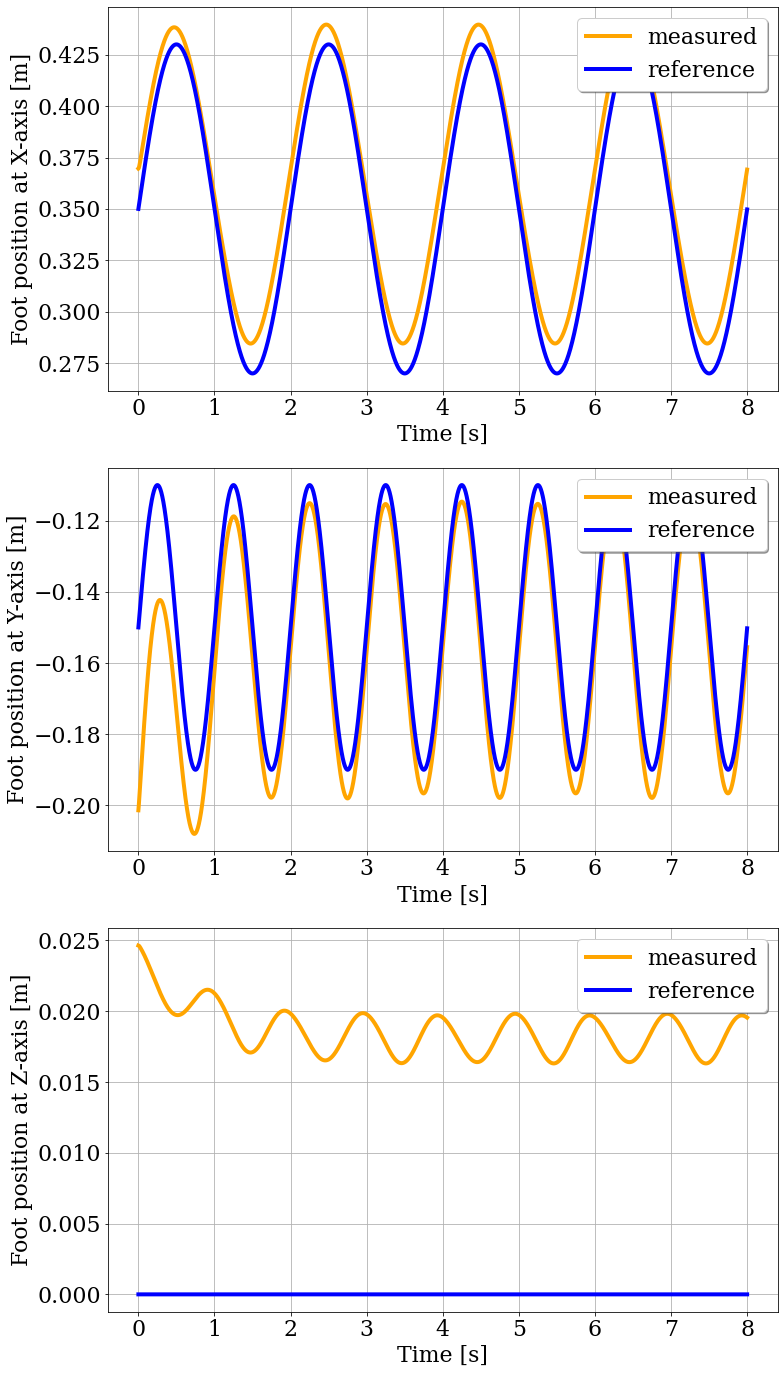

In [11]:
measured_foot_positions = np.vstack((x_pos, y_pos, z_pos)).T
plot_foot_positions(simulation_time, measured_foot_positions, desired_foot_positions)

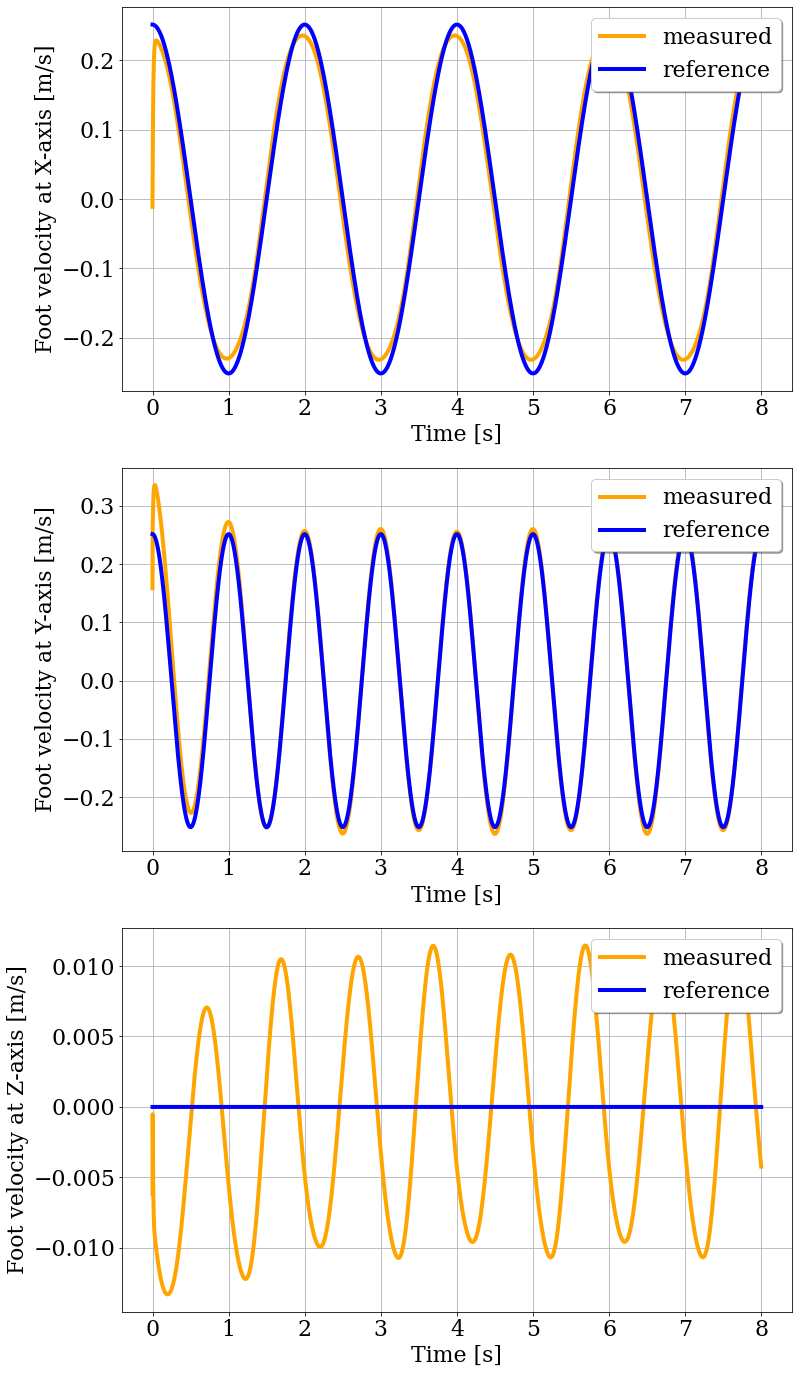

In [12]:
measured_foot_velocities = np.vstack((x_vel, y_vel, z_vel)).T
plot_foot_velocities(simulation_time, measured_foot_velocities, desired_foot_velocities)